## Download model and convert model

In [3]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='civitai_model.ckpt'\
      --original_config_file='v1-inference.yaml'\
      --dump_path='Civitai_converted'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors

## Training full model

In [ ]:
!python3 diffusers/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path='Civitai_converted' \
  --instance_data_dir='reeves_cropped' \
  --class_data_dir='class_imgs' \
  --output_dir='reeves_model_512' \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man, random head angle, slight smile" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="fp16"\
  --train_text_encoder \
  --enable_xformers_memory_efficient_attention


## Inference

In [30]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

# model_path = "reeves_model_512/"
model_path = 'Civitai_converted'

pipe = StableDiffusionPipeline.from_pretrained(
    model_path, safety_checker=None, torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda = None

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [31]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(123)

100%|██████████| 35/35 [00:04<00:00,  7.57it/s]


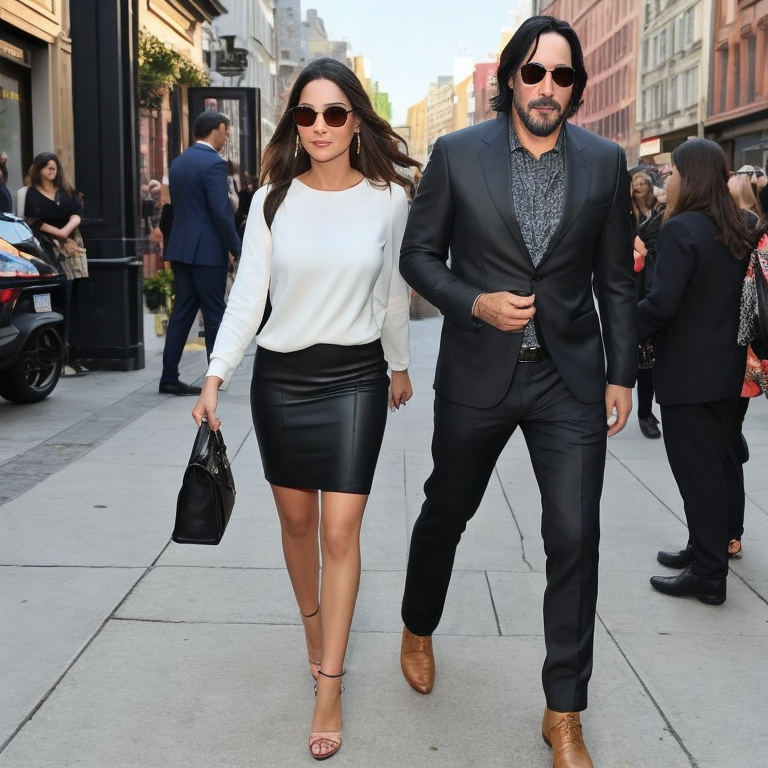

In [12]:
# @title Run for generating images.

# prompt = "portrait of man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes" #@param {type:"string"}
# prompt = "a photo of keanu reeves, random head angle, random smile, wrinkles" #@param {type:"string"}
# prompt = "a photo of sks man face with umbrella" #@param {type:"string"}
prompt = "a photo of a man sks with girlfriend"  # @param {type:"string"}
negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
num_samples = 1  # @param {type:"number"}
guidance_scale = 5  # @param {type:"number"}
num_inference_steps = 35  # @param {type:"number"}
height = 768  # @param {type:"number"}
width = 768  # @param {type:"number"}

with torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
    ).images

for img in images:
    display(img)


In [3]:
token = "sks"
promt_list = [
    {
        "name": "sunglasses",
        "prompt": f"a photo of a man {token} in sunglasses",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "girlfrind",
        "prompt": f"a photo of a man {token} with girlfriend",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "umbrella",
        "prompt": f"a photo of a man {token} with umbrella",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "kitchen",
        "prompt": f"close up portrait of {token} man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "forest",
        "prompt": f"portrait of {token} man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "street",
        "prompt": f"portrait of {token} man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
]

from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [33]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "report_images"
save_mode = "reeves_model_v"

for idx, sample in enumerate(promt_list):
    prompt = sample.get("prompt")
    negative_prompt = sample.get("n_prompt")
    name = sample.get("name")
    image_list = []
    for _ in range(repeat):
        generator = torch.Generator("cuda").manual_seed(seed)
        with autocast("cuda"), torch.inference_mode():
            images = pipe(
                prompt,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        image_list.extend(images)
        seed += 345324

    img_grid = image_grid(image_list, num_samples, repeat)
    save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
    os.makedirs(save_path, exist_ok=True)
    img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|██████████| 35/35 [00:13<00:00,  2.65it/s]


## Training LoRA adapter

In [23]:
!python3 diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path='Civitai_converted' \
  --instance_data_dir='reeves_cropped' \
  --class_data_dir='class_imgs' \
  --output_dir='reeves_model_512_lora_r8' \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man, random head angle, slight smile" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --rank=8 \
  --train_batch_size=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="fp16"\
  --train_text_encoder \
  --enable_xformers_memory_efficient_attention


/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/accelerate/accelerator.py:391: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/17/2024 02:36:24 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you a

In [1]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

model_path = "Civitai_converted"
lora_weights = "reeves_model_512_lora_r8"

pipe = StableDiffusionPipeline.from_pretrained(
    model_path, safety_checker=None, torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda = None

pipe.load_lora_weights(lora_weights)

/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_stora

100%|██████████| 35/35 [00:04<00:00,  7.18it/s]


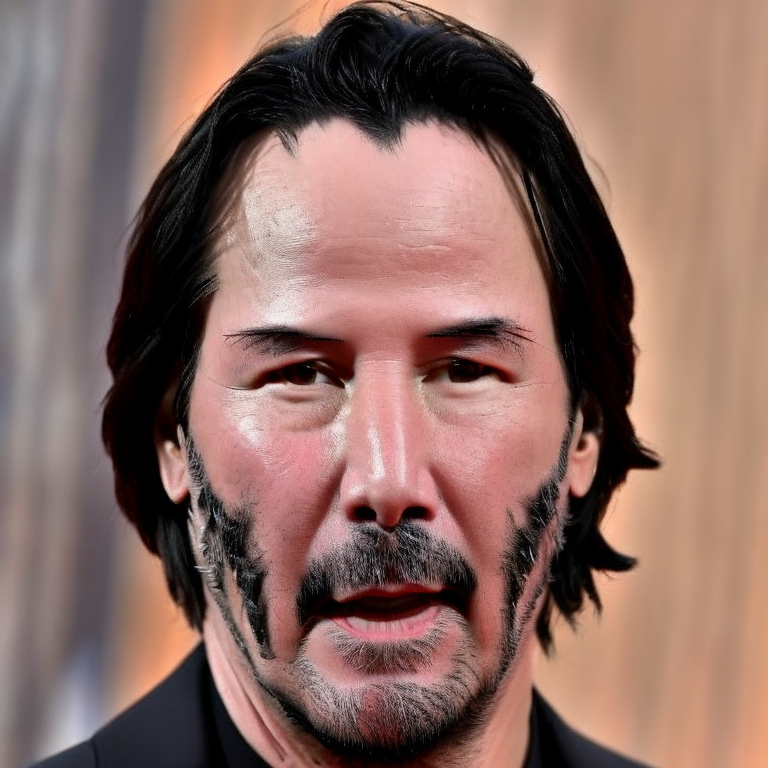

In [99]:
# @title Run for generating images.

# prompt = "portrait of man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes" #@param {type:"string"}
# prompt = "a photo of keanu reeves, random head angle, random smile, wrinkles" #@param {type:"string"}
prompt = "a photo of sks keanu reeves man face" #@param {type:"string"}
# prompt = "portrait of sks man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focusclose up portrait of sks man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus"  # @param {type:"string"}
negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
num_samples = 1  # @param {type:"number"}
guidance_scale = 7.5  # @param {type:"number"}
num_inference_steps = 35  # @param {type:"number"}
height = 768  # @param {type:"number"}
width = 768  # @param {type:"number"}

with torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
    ).images

for img in images:
    display(img)
    # img.save(f"class_imgs/img_{i}.png", format="png")
    # i += 1

In [20]:
token = "sks"
promt_list = [
    {
        "name": "sunglasses",
        "prompt": f"a photo of a man {token} in sunglasses",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "girlfrind",
        "prompt": f"a photo of a man {token} with girlfriend",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "umbrella",
        "prompt": f"a photo of a man {token} with umbrella",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "kitchen",
        "prompt": f"close up portrait of {token} man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "forest",
        "prompt": f"portrait of {token} man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "street",
        "prompt": f"portrait of {token} man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
]

from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [3]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "report_images_lora"
save_mode = "reeves_model_512_lora_r8"

for idx, sample in enumerate(promt_list):
    prompt = sample.get("prompt")
    negative_prompt = sample.get("n_prompt")
    name = sample.get("name")
    image_list = []
    for _ in range(repeat):
        generator = torch.Generator("cuda").manual_seed(seed)
        with autocast("cuda"), torch.inference_mode():
            images = pipe(
                prompt,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        image_list.extend(images)
        seed += 345324

    img_grid = image_grid(image_list, num_samples, repeat)
    save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
    os.makedirs(save_path, exist_ok=True)
    img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|██████████| 35/35 [00:14<00:00,  2.43it/s]


In [7]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import torch

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

# model_id = "reeves_model_512"
model_id = "Civitai_converted"
lora_weights = "reeves_model_512_lora_r1"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()
pipe.load_lora_weights(lora_weights)

Loading pipeline components...:  57%|█████▋    | 4/7 [00:04<00:03,  1.17s/it]/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


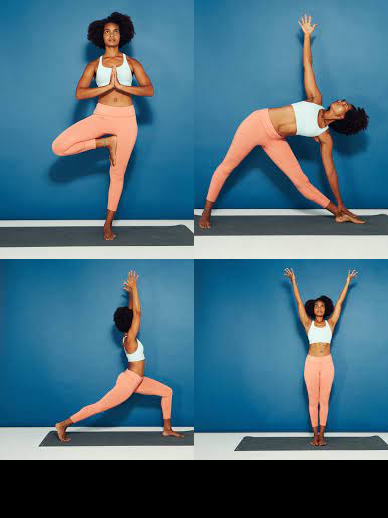

In [4]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in urls
]

image_grid(imgs, 2, 2)

/home/shace_linux/projects/itmo_gan_course/venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


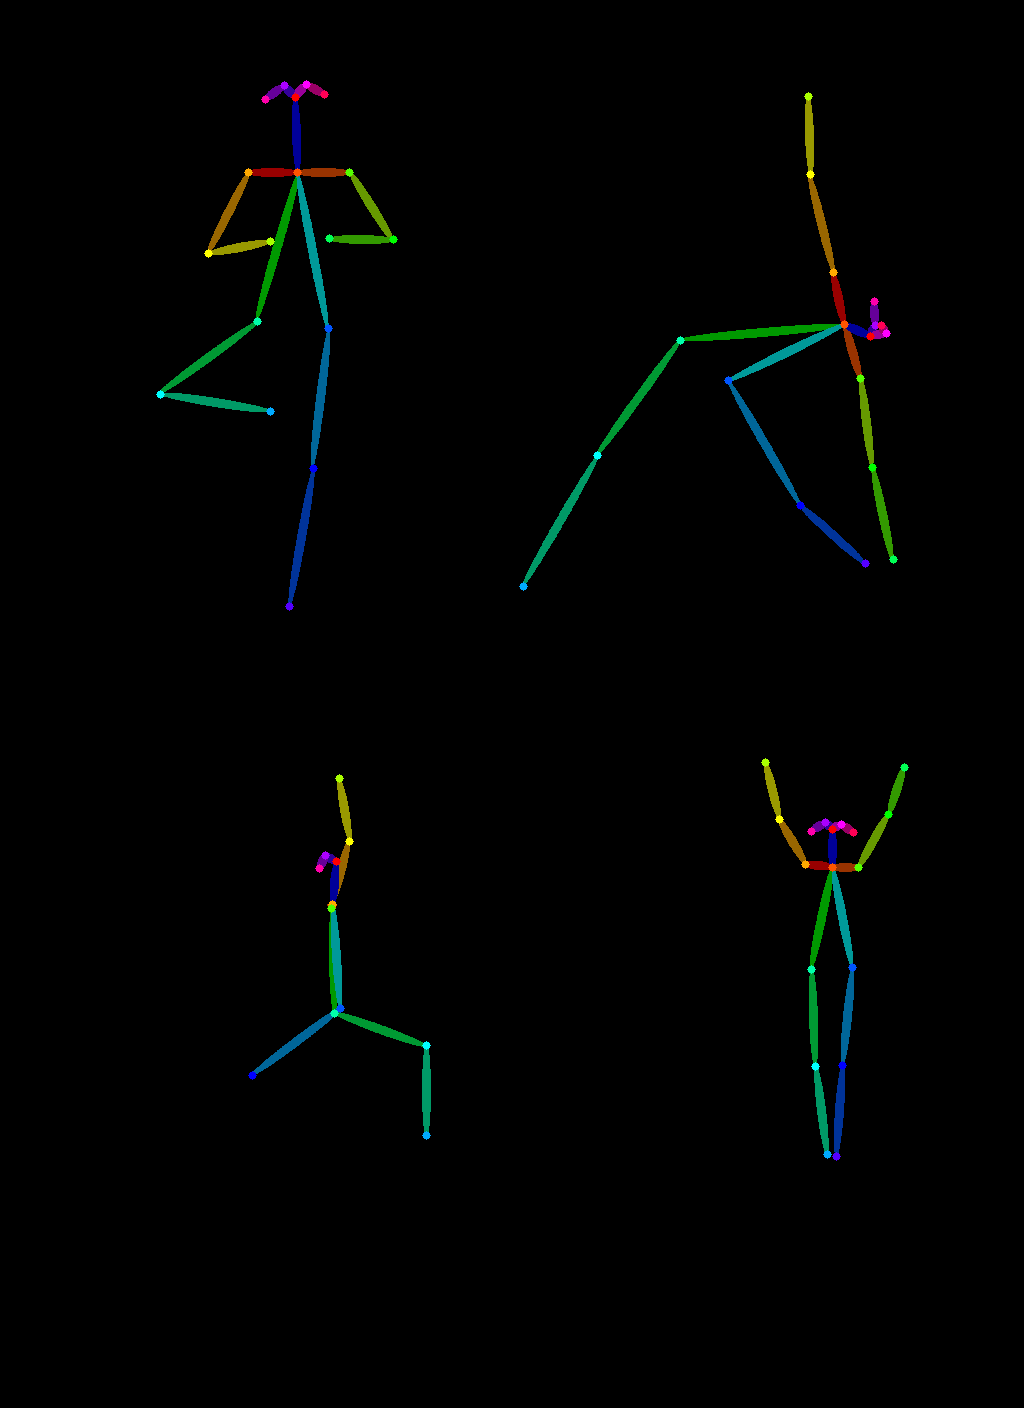

In [5]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [8]:
import torch
from torch import autocast
import os
from random import choice


seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "report_images_lora"
save_mode = "reeves_model_512_lora_r1_cnet"

for idx, sample in enumerate(promt_list):
    prompt = sample.get("prompt")
    negative_prompt = sample.get("n_prompt")
    name = sample.get("name")
    image_list = []
    for _ in range(repeat):
        generator = torch.Generator("cuda").manual_seed(seed)
        with autocast("cuda"), torch.inference_mode():
            images = pipe(
                prompt,
                choice(poses),
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        image_list.extend(images)
        seed += 345324

    img_grid = image_grid(image_list, num_samples, repeat)
    save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
    os.makedirs(save_path, exist_ok=True)
    img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|██████████| 35/35 [00:17<00:00,  2.03it/s]
